https://www.youtube.com/watch?v=Z_ikDlimN6A&t=71011

# Standard setup

In [19]:
from torch.utils.data.dataset import Dataset
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split

import torchvision
from torchvision import datasets
from torchvision.transforms import v2 as transforms

import random

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import requests
from pathlib import Path
import zipfile

from timeit import default_timer as timer

import os

try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

try:
  import torchmetrics, mlxtend
  assert int(mlxtend.__version__.split(".")[1])>=19, "mlxtend version should be 0.19.0 or higher"
except:
  !pip install torchmetrics -U mlxtend
  import torchmetrics, mlxtend

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

print(f"PyTorch version: {torch.__version__}")
print(f"PyTorch torchvision version: {torchvision.__version__}")

device = torch.accelerator.current_accelerator() if torch.accelerator.is_available() else torch.device("cpu")
print(f"Torch device: {device}")
if torch.cuda.is_available():
    for device_id in range(torch.cuda.device_count()):
        print(f"Found CUDA device: cuda:{device_id} - {torch.cuda.get_device_name(device_id)}")

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import accuracy_fn

def plt_random_sample_from_data(data: Dataset, rows: int, cols: int, random_seed: int = None):
  if random_seed:
    random.seed(random_seed)
  samples = random.sample(list(data), rows*cols)

  fig = plt.figure(figsize=(rows*2,cols*2))
  for index, sample in enumerate(samples) :
    image = sample[0]
    label = sample[1]

    plt.subplot(cols, rows, index+1)
    plt.imshow(transforms.ToPILImage()(image))
    plt.title(f"{data.classes[label].capitalize()}\n{str(image.shape)[10:]}, {str(image.dtype)[6:]}", fontsize=8)
    plt.axis(False)
  fig.tight_layout()
  plt.show()

def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
    """Returns a dictionary containing the results of model prediction on data_loader"""
    loss, acc = 0,0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader, "Evaluating model batch"):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)

            # Accumulate loss and acc per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        # Scale loss and acc to find average per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {
        "model_name": model.__class__.__name__,
        "model_loss": loss.item(),
        "model_acc": acc
    } # only works when the model was created with a class

def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints differene between start and end time."""
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time


PyTorch version: 2.8.0+cu126
PyTorch torchvision version: 0.23.0+cu126
Torch device: cuda
Found CUDA device: cuda:0 - Tesla T4
helper_functions.py already exists, skipping download


# Get our data

We're starting with the food 101 data set, but limiting it to 3 classes (Pizza, steak and sushi) and then only using 10% of the images from those classes for each of the training and test subsets.

In [3]:
data_path= Path("data/")
image_path= data_path / "pizza_steak_sushi"

# If the data already exists, don't download again
if image_path.is_dir():
  print(f"{image_path} directory already exists, not downloading")
else:
  print(f"{image_path} does not exist, creating")
  image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, sushi data")
  f.write(request.content)

with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza_steak_sushi data")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi does not exist, creating
Unzipping pizza_steak_sushi data


# Data preperation and data exploration

In [58]:
# def walk_through_dir(dir_path):
#   """Walks through a dir_path returning its contents."""
#   for dirpath, dirnames, filenames in os.walk(dir_path):
#     print(f"There are {len(dirnames)} and {len(filenames)} in '{dirpath}'")

# walk_through_dir(dir_path=image_path)

train_dir = image_path / "train"
test_dir = image_path / "test"

data_transform = transforms.Compose([
    transforms.Resize(size=(64,64), antialias=True),
    # Randomly flip on the horizontal axis, 50% of the images
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True)
])

# You could also do this the hard way, see
# https://www.learnpytorch.io/04_pytorch_custom_datasets/#5-option-2-loading-image-data-with-a-custom-dataset
train_data = datasets.ImageFolder(root=train_dir,
                     transform=data_transform
                     )
test_data = datasets.ImageFolder(root=test_dir,
                     transform=data_transform
                     )

BATCH_SIZE = 32
SPARE_THREADS = 2

train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count())
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count())

## Show a random image.

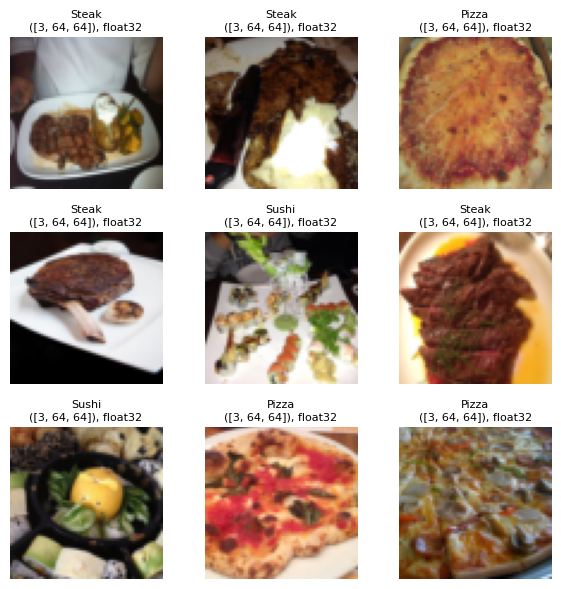

In [59]:
plt_random_sample_from_data(train_data, 3 ,3)

https://www.youtube.com/watch?v=Z_ikDlimN6A&t=80480

# Data Augmentation

Used to artificially increase the diversity in our training data

https://docs.pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_illustrations.html#augmentation-transforms

Looking at one particular type of data augmentation used to train PyTorch vision models to (2022) state of the art levels.

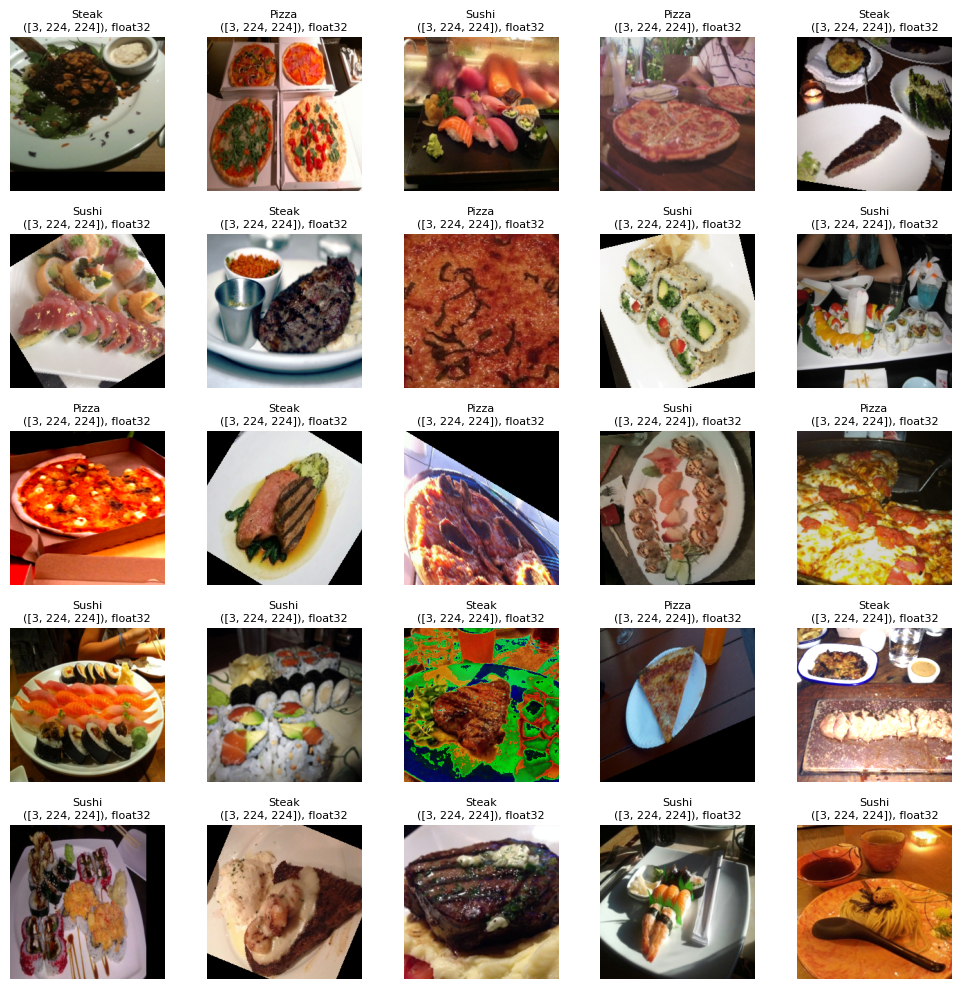

In [60]:
train_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True)
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True)
])

train_data_augmented = datasets.ImageFolder(root=train_dir,
                     transform=train_transform
                     )
test_data_augmented = datasets.ImageFolder(root=test_dir,
                     transform=test_transform
                     )

plt_random_sample_from_data(train_data_augmented, cols=5, rows=5)

#Creating a model

https://www.youtube.com/watch?v=Z_ikDlimN6A&t=81767

In [4]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dir = image_path / "train"
test_dir = image_path / "test"

simple_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True)
])

train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform
                                         )
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform
                                        )


train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE, shuffle=True,
                                     num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE, shuffle=False,
                                    num_workers=NUM_WORKERS)

In [5]:
#TinyVGG Baseline
class TinyVGG(nn.Module):
  """
  Model architecture that replicates the TinyVGG model from CNN explainer
  website. The data is expected to be a data batch, so 4 dimensions, and it
  works on RGB images of 64x64
  """
  def __init__(self, input_shape:int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=output_shape)
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.classifier(self.conv_block_2(self.conv_block_1(x))) # benifits from operator fusion, see https://horace.io/brrr_intro.html


In [6]:
torch.manual_seed(42)
if torch.cuda.is_available():
  torch.cuda.manual_seed(42)

model_0 = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(train_data_simple.classes)).to(device)

torchinfo.summary(model_0, input_size=[32,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 30, 30]          --
│    └─Conv2d: 2-1                       [32, 10, 62, 62]          280
│    └─ReLU: 2-2                         [32, 10, 62, 62]          --
│    └─Conv2d: 2-3                       [32, 10, 60, 60]          910
│    └─ReLU: 2-4                         [32, 10, 60, 60]          --
│    └─MaxPool2d: 2-5                    [32, 10, 30, 30]          --
├─Sequential: 1-2                        [32, 10, 13, 13]          --
│    └─Conv2d: 2-6                       [32, 10, 28, 28]          910
│    └─ReLU: 2-7                         [32, 10, 28, 28]          --
│    └─Conv2d: 2-8                       [32, 10, 26, 26]          910
│    └─ReLU: 2-9                         [32, 10, 26, 26]          --
│    └─MaxPool2d: 2-10                   [32, 10, 13, 13]          --
├─Sequentia

In [16]:
def model_train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimiser: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    """Performs a training step with model trying to learn on data_loader"""

    train_loss, train_acc = 0, 0

    model.train()

    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        optimiser.zero_grad()

        loss.backward()

        optimiser.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    print(f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.2f}%")

def model_test_step(model: torch.nn.Module,
                 device: torch.device,
                 data_loader: torch.utils.data.DataLoader,
                 loss_fn: torch.nn.Module,
                 accuracy_fn,
                 ):
    """Performs a testing step with model trying to test the trained model using data_loader"""
    test_loss, test_acc = 0, 0

    model.eval()
    with torch.inference_mode():
        for batch, (X,y) in enumerate(data_loader):
            X, y = X.to(device), y.to(device)
            test_pred = model(X)

            test_loss += loss_fn(test_pred, y)

            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}%")

def train(epochs: int, model: nn.Module,
          optimiser: torch.optim.Optimizer,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          accuracy_fn,
          loss_fn: torch.nn.Module,
          device: torch.device
          ):
  for epoch in tqdm(range(epochs), "Training..."):
      model_train_step(model=model, data_loader=train_dataloader,
                loss_fn=loss_fn, optimiser=optimiser, device=device,
                accuracy_fn=accuracy_fn)

      model_test_step(model=model, device=device, data_loader=test_dataloader,
                  loss_fn=loss_fn, accuracy_fn=accuracy_fn)


Training...:   0%|          | 0/10 [00:00<?, ?it/s]

Train loss: 1.1096, Train acc: 30.47%
Test loss: 1.1092, Test acc: 26.0417%
Train loss: 1.0999, Train acc: 30.47%
Test loss: 1.1231, Test acc: 19.7917%
Train loss: 1.0971, Train acc: 29.30%
Test loss: 1.1285, Test acc: 26.0417%
Train loss: 1.1101, Train acc: 30.47%
Test loss: 1.1013, Test acc: 26.0417%
Train loss: 1.1013, Train acc: 30.47%
Test loss: 1.1172, Test acc: 19.7917%
Train loss: 1.0982, Train acc: 29.30%
Test loss: 1.1238, Test acc: 26.0417%
Train loss: 1.1087, Train acc: 30.47%
Test loss: 1.0990, Test acc: 26.0417%
Train loss: 1.1022, Train acc: 30.47%
Test loss: 1.1151, Test acc: 19.7917%
Train loss: 1.0978, Train acc: 29.30%
Test loss: 1.1217, Test acc: 26.0417%
Train loss: 1.0994, Train acc: 30.47%
Test loss: 1.1331, Test acc: 19.7917%
Train time on cuda:0: 10.424 seconds


Evaluating model batch:   0%|          | 0/3 [00:00<?, ?it/s]

model_0 evaluation: {'model_name': 'TinyVGG', 'model_loss': 1.1331477165222168, 'model_acc': 19.791666666666668}


Making predictions...:   0%|          | 0/3 [00:00<?, ?it/s]

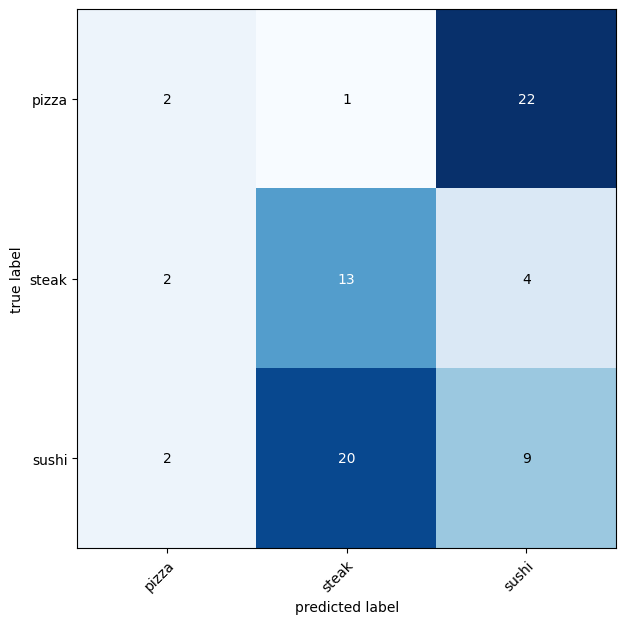

In [20]:
# Setup loss function
loss_fn = nn.CrossEntropyLoss()

# Setup optimiser function
optimiser = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

EPOCHS = 10

train_time_start = timer()
train(epochs=EPOCHS, model=model_0, optimiser=optimiser,
      train_dataloader=train_dataloader_simple,
      test_dataloader=test_dataloader_simple,
      accuracy_fn=accuracy_fn, loss_fn=loss_fn, device=device)
train_time_end = timer()
total_train_time_model_0 = print_train_time(start=train_time_start,
                                            end=train_time_end,
                                            device=str(next(model_0.parameters()).device))

model_0_results = eval_model(model=model_0, data_loader=test_dataloader_simple,
                            loss_fn=loss_fn, accuracy_fn=accuracy_fn)

print(f"model_0 evaluation: {model_0_results}")

y_preds = []
targets = []
model_0.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader_simple, desc="Making predictions..."):
        X, y = X.to(device), y.to(device)
        y_logits = model_0(X)
        #Turn logits to preds to labels
        y_pred = torch.softmax(y_logits.squeeze(), dim=0).argmax(dim=1)
        y_preds.append(y_pred.cpu())
        targets.append(y)

y_pred_tensor = torch.cat(y_preds)
targets_tensor = torch.cat(targets).to("cpu")

conf_mat = ConfusionMatrix(num_classes=len(test_data_simple.classes), task="multiclass")
conf_mat_tensor = conf_mat(preds=y_pred_tensor, target=targets_tensor)

fig, axis = plot_confusion_matrix(conf_mat=conf_mat_tensor.numpy(),
                                  class_names=test_data_simple.classes,
                                  figsize=(10,7)
                                  )
fig.show()